In [1]:
!pip install vk_api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.3 MB/s eta 0:00:00


In [42]:
import time
import pandas as pd
import vk_api # https://github.com/python273/vk_api
from google.colab import userdata
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [3]:
# lib 'vk_api' works with only this app id
# google another if it stops working in the future
API_APP_ID = 2685278

In [4]:
def auth_handler():
    # Код двухфакторной аутентификации
    key = input("Enter authentication code: ")
    # Если: True - сохранить, False - не сохранять.
    remember_device = True

    return key, remember_device

In [5]:
#api = vk_requests.create_api(service_token=TOKEN)
session = vk_api.VkApi(userdata.get('login'),
                       userdata.get('password'),
                       app_id=API_APP_ID,
                       auth_handler=auth_handler)
session.auth()
api = session.get_api()

Enter authentication code: 618320


In [6]:
# get selected number of group members
# if $max_number_of_members = -1, get all group members
# out: {'count': number of members in the group (int),
#       'items': group member ids (len(items) <= $max_number_of_members) (list)}
def get_group_members(group_id: str, max_number_of_members: int = -1) -> dict:
    batch = 1000
    full_response = {}
    member_ids = []
    total_members = api.groups.getMembers(group_id=group_id, count=1)['count']

    if max_number_of_members > -1:
        total_members = min(total_members, max_number_of_members)

    while True:
        response = api.groups.getMembers(group_id=group_id, count=batch,
                                        offset=len(member_ids))
        member_ids += response['items']
        print(f'{len(member_ids)} / {total_members}')

        if ((len(response['items']) < batch)
        or (max_number_of_members > -1
            and len(member_ids) >= max_number_of_members)):
            full_response = response

            if (max_number_of_members > -1
                and max_number_of_members < len(member_ids)):
                member_ids = member_ids[:max_number_of_members]

            if len(member_ids) > total_members:
                member_ids = member_ids[:total_members]

            full_response['items'] = member_ids
            break;

    return full_response

In [7]:
group1_id = 'vikiperm'
group2_id = 'hsemem'

In [8]:
group1 = get_group_members(group1_id)

1000 / 534244
2000 / 534244
3000 / 534244
4000 / 534244
5000 / 534244
6000 / 534244
7000 / 534244
8000 / 534244
9000 / 534244
10000 / 534244
11000 / 534244
12000 / 534244
13000 / 534244
14000 / 534244
15000 / 534244
16000 / 534244
17000 / 534244
18000 / 534244
19000 / 534244
20000 / 534244
21000 / 534244
22000 / 534244
23000 / 534244
24000 / 534244
25000 / 534244
26000 / 534244
27000 / 534244
28000 / 534244
29000 / 534244
30000 / 534244
31000 / 534244
32000 / 534244
33000 / 534244
34000 / 534244
35000 / 534244
36000 / 534244
37000 / 534244
38000 / 534244
39000 / 534244
40000 / 534244
41000 / 534244
42000 / 534244
43000 / 534244
44000 / 534244
45000 / 534244
46000 / 534244
47000 / 534244
48000 / 534244
49000 / 534244
50000 / 534244
51000 / 534244
52000 / 534244
53000 / 534244
54000 / 534244
55000 / 534244
56000 / 534244
57000 / 534244
58000 / 534244
59000 / 534244
60000 / 534244
61000 / 534244
62000 / 534244
63000 / 534244
64000 / 534244
65000 / 534244
66000 / 534244
67000 / 534244
6800

In [9]:
group2 = get_group_members(group2_id)

1000 / 90212
2000 / 90212
3000 / 90212
4000 / 90212
5000 / 90212
6000 / 90212
7000 / 90212
8000 / 90212
9000 / 90212
10000 / 90212
11000 / 90212
12000 / 90212
13000 / 90212
14000 / 90212
15000 / 90212
16000 / 90212
17000 / 90212
18000 / 90212
19000 / 90212
20000 / 90212
21000 / 90212
22000 / 90212
23000 / 90212
24000 / 90212
25000 / 90212
26000 / 90212
27000 / 90212
28000 / 90212
29000 / 90212
30000 / 90212
31000 / 90212
32000 / 90212
33000 / 90212
34000 / 90212
35000 / 90212
36000 / 90212
37000 / 90212
38000 / 90212
39000 / 90212
40000 / 90212
41000 / 90212
42000 / 90212
43000 / 90212
44000 / 90212
45000 / 90212
46000 / 90212
47000 / 90212
48000 / 90212
49000 / 90212
50000 / 90212
51000 / 90212
52000 / 90212
53000 / 90212
54000 / 90212
55000 / 90212
56000 / 90212
57000 / 90212
58000 / 90212
59000 / 90212
60000 / 90212
61000 / 90212
62000 / 90212
63000 / 90212
64000 / 90212
65000 / 90212
66000 / 90212
67000 / 90212
68000 / 90212
69000 / 90212
70000 / 90212
71000 / 90212
72000 / 90212
7

In [10]:
# get only ids
members1 = group1['items']
members2 = group2['items']
user_fields = ['bdate', 'sex', 'country', 'city']

In [11]:
def get_users_info(user_ids: list, fields: list) -> pd.DataFrame:
    batch = 1000
    k = 0
    result = pd.DataFrame()

    while batch * k < len(user_ids):
        response = api.users.get(user_ids=user_ids[batch * k:batch * (k + 1)],
                                fields=fields)
        table = pd.json_normalize(response)
        k += 1

        if len(result) == 0:
            result = table
        else:
            result = pd.concat([result, table])

        print(f'{len(result.index)} / {len(user_ids)}')

    if len(result) > len(user_ids):
        result = result[:len(user_ids)]

    return result

In [12]:
df_group1 = get_users_info(members1, user_fields)

1000 / 534244
2000 / 534244
3000 / 534244
4000 / 534244
5000 / 534244
6000 / 534244
7000 / 534244
8000 / 534244
9000 / 534244
10000 / 534244
11000 / 534244
12000 / 534244
13000 / 534244
14000 / 534244
15000 / 534244
16000 / 534244
17000 / 534244
18000 / 534244
19000 / 534244
20000 / 534244
21000 / 534244
22000 / 534244
23000 / 534244
24000 / 534244
25000 / 534244
26000 / 534244
27000 / 534244
28000 / 534244
29000 / 534244
30000 / 534244
31000 / 534244
32000 / 534244
33000 / 534244
34000 / 534244
35000 / 534244
36000 / 534244
37000 / 534244
38000 / 534244
39000 / 534244
40000 / 534244
41000 / 534244
42000 / 534244
43000 / 534244
44000 / 534244
45000 / 534244
46000 / 534244
47000 / 534244
48000 / 534244
49000 / 534244
50000 / 534244
51000 / 534244
52000 / 534244
53000 / 534244
54000 / 534244
55000 / 534244
56000 / 534244
57000 / 534244
58000 / 534244
59000 / 534244
60000 / 534244
61000 / 534244
62000 / 534244
63000 / 534244
64000 / 534244
65000 / 534244
66000 / 534244
67000 / 534244
6800

In [13]:
df_group2 = get_users_info(members2, user_fields)

1000 / 90212
2000 / 90212
3000 / 90212
4000 / 90212
5000 / 90212
6000 / 90212
7000 / 90212
8000 / 90212
9000 / 90212
10000 / 90212
11000 / 90212
12000 / 90212
13000 / 90212
14000 / 90212
15000 / 90212
16000 / 90212
17000 / 90212
18000 / 90212
19000 / 90212
20000 / 90212
21000 / 90212
22000 / 90212
23000 / 90212
24000 / 90212
25000 / 90212
26000 / 90212
27000 / 90212
28000 / 90212
29000 / 90212
30000 / 90212
31000 / 90212
32000 / 90212
33000 / 90212
34000 / 90212
35000 / 90212
36000 / 90212
37000 / 90212
38000 / 90212
39000 / 90212
40000 / 90212
41000 / 90212
42000 / 90212
43000 / 90212
44000 / 90212
45000 / 90212
46000 / 90212
47000 / 90212
48000 / 90212
49000 / 90212
50000 / 90212
51000 / 90212
52000 / 90212
53000 / 90212
54000 / 90212
55000 / 90212
56000 / 90212
57000 / 90212
58000 / 90212
59000 / 90212
60000 / 90212
61000 / 90212
62000 / 90212
63000 / 90212
64000 / 90212
65000 / 90212
66000 / 90212
67000 / 90212
68000 / 90212
69000 / 90212
70000 / 90212
71000 / 90212
72000 / 90212
7

In [14]:
df_group2.head()

,id,bdate,sex,first_name,last_name,can_access_closed,is_closed,city.id,city.title,country.id,country.title,deactivated
0,1257,19.10.1989,2,Oleg,Urzhumtsev,True,False,2204899.0,İstanbul,200.0,Turkey,NaN
1,1389,NaN,2,Ivan,Bezborody,False,True,95.0,Nizhny Novgorod,1.0,Russia,NaN
2,2050,27.4,1,Katya,Lebedeva,True,False,2.0,Saint Petersburg,1.0,Russia,NaN
3,2932,NaN,2,Kirill,Kogortov,True,False,2.0,Saint Petersburg,1.0,Russia,NaN
4,4913,5.2.1984,1,Marina,Sekacheva,False,True,2.0,Saint Petersburg,1.0,Russia,NaN


In [15]:
def drop_useless_users(df: pd.DataFrame) -> pd.DataFrame:
    print(f'Before: {len(df.index)}')

    df_clear = df.loc[df['deactivated'] != 'banned']
    print(f'After removing banned users: {len(df_clear.index)}')

    df_clear = df_clear.loc[df_clear['deactivated'] != 'deleted']
    print(f'After removing deleted users: {len(df_clear.index)}')

    df_clear = df_clear.loc[df_clear['bdate'].str.len() > 7]
    print(f'After removing users without birth year: {len(df_clear.index)}')

    df_clear = df_clear.dropna(subset=['city.title'])
    print(f'After removing users without city: {len(df_clear.index)}')

    df_clear = df_clear.loc[df_clear['sex'] != 0]
    print(f'After removing users with unknown sex: {len(df_clear.index)}')

    df_clear['byear'] = df_clear['bdate'].str[-4:].apply(pd.to_numeric)

    return df_clear

In [16]:
dr_group1_cleared = drop_useless_users(df_group1)

Before: 534244
After removing banned users: 509682
After removing deleted users: 454998
After removing users without birth year: 194567
After removing users without city: 137851
After removing users with unknown sex: 137841


In [17]:
dr_group2_cleared = drop_useless_users(df_group2)

Before: 90212
After removing banned users: 89102
After removing deleted users: 86138
After removing users without birth year: 31112
After removing users without city: 22321
After removing users with unknown sex: 22321


In [18]:
# экспортируем таблицы в эксель
dr_group1_cleared.to_excel(f'{group1_id}.xlsx')
dr_group2_cleared.to_excel(f'{group2_id}.xlsx')

In [19]:
def piechart_sex(df: pd.DataFrame):
    plt.figure(figsize=(15, 8))
    plt.pie([len(df.loc[df['sex'] == 1].index),
            len(df.loc[df['sex'] == 2].index)],
            labels=['Женский', 'Мужской'], autopct='%.0f%%')
    plt.title('Соотношение полов')
    plt.show()

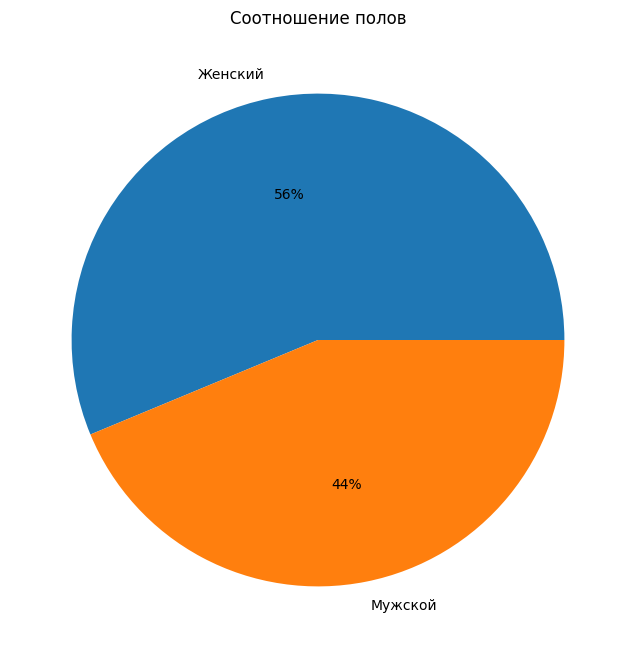

In [20]:
piechart_sex(dr_group1_cleared)

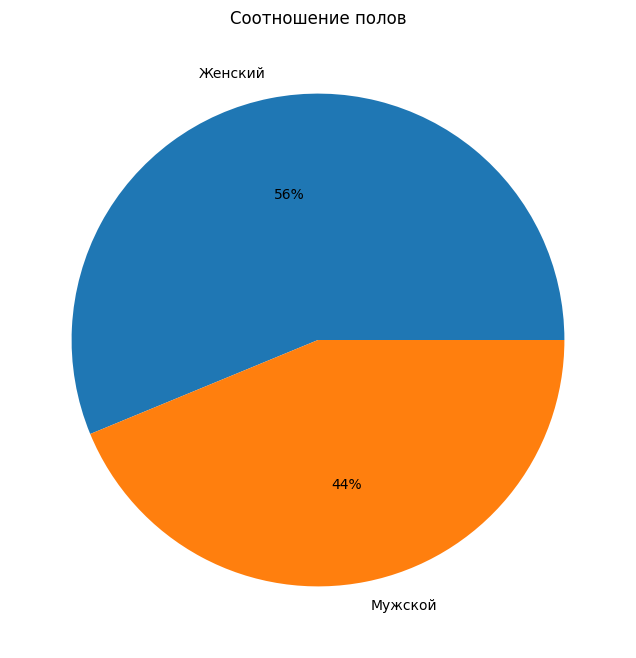

In [21]:
piechart_sex(dr_group2_cleared)

In [22]:
def countplot_birth_year(df: pd.DataFrame):
    plt.figure(figsize=(8, 15))
    sns.countplot(y=df.sort_values(by=['byear'])['byear'])
    plt.title('Годы рождения')
    plt.show()

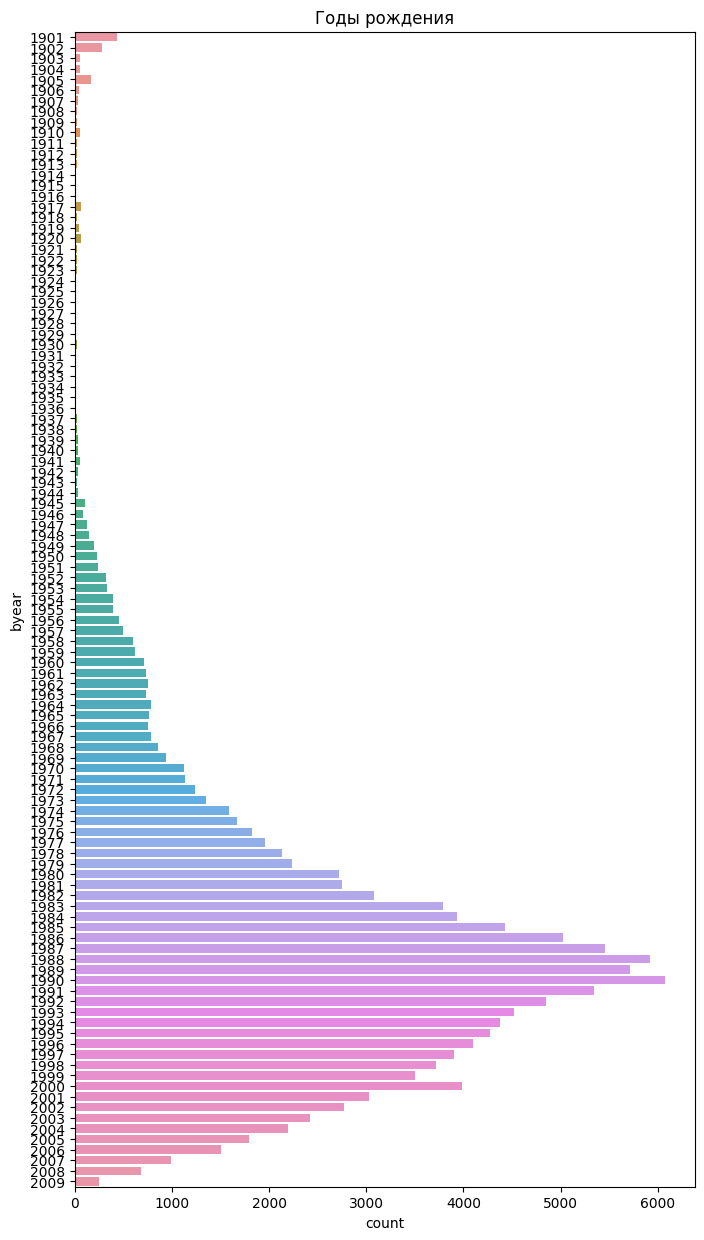

In [23]:
countplot_birth_year(dr_group1_cleared)

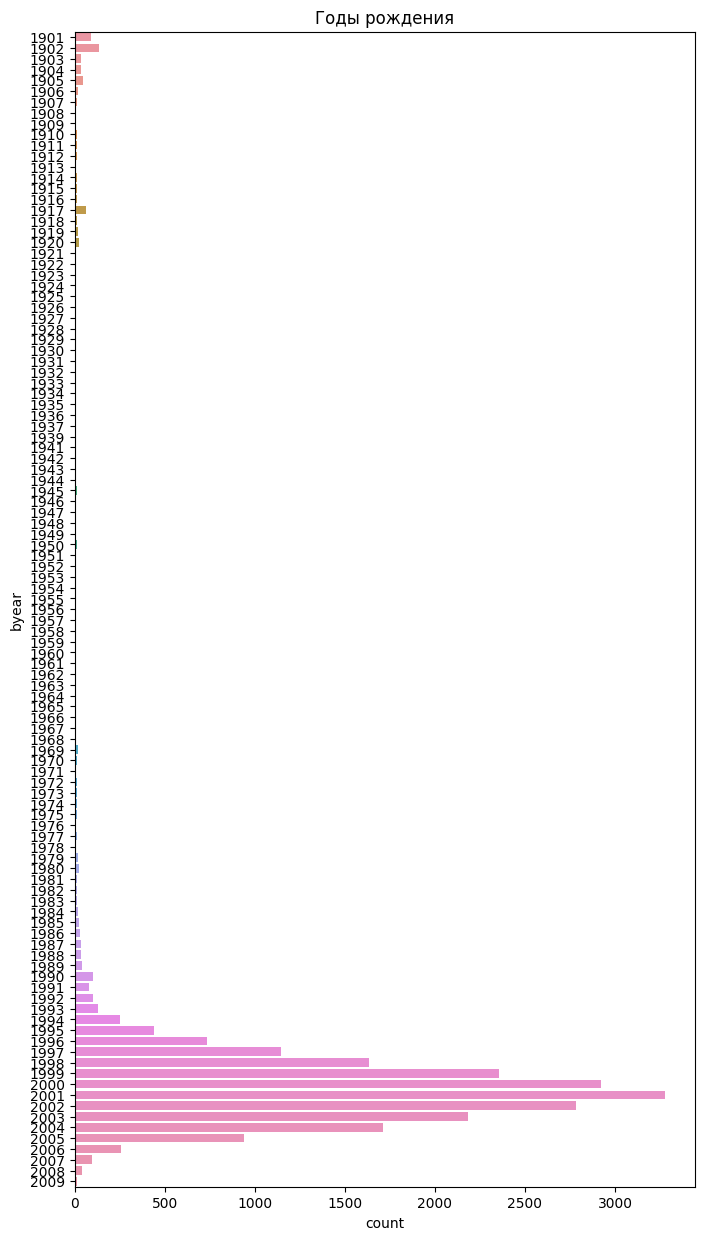

In [24]:
countplot_birth_year(dr_group2_cleared)

In [25]:
avg1 = dr_group1_cleared.loc[(dr_group1_cleared['byear'] > 1920)]['byear'].mean()
avg2 = dr_group2_cleared.loc[(dr_group2_cleared['byear'] > 1920)]['byear'].mean()
print(f'Average birth year in {group1_id}: {round(avg1)}')
print(f'Average birth year in {group2_id}: {round(avg2)}')

Average birth year in vikiperm: 1987
Average birth year in hsemem: 2000


In [26]:
intersection = set(members1) & set(members2)
print(f'Количество пользователей в первой группе ({group1_id}): {len(members1)}')
print(f'Количество пользователей во второй группе ({group2_id}): {len(members2)}')
print(f'Количество пользователей, состоящих в обеих группах: {len(intersection)}')

Количество пользователей в первой группе (vikiperm): 534244
Количество пользователей во второй группе (hsemem): 90212
Количество пользователей, состоящих в обеих группах: 1203


In [27]:
def countplot_city(df: pd.DataFrame, top: int = 100, skip_first: int = 0):
    plt.figure(figsize=(15, 25))
    top_50 = (df['city.title'].value_counts()).iloc[skip_first:top + skip_first]
    plt.barh(top_50.index, top_50)
    plt.yticks(fontsize=14)
    plt.grid(axis='x')
    plt.title('По городам')
    plt.show()

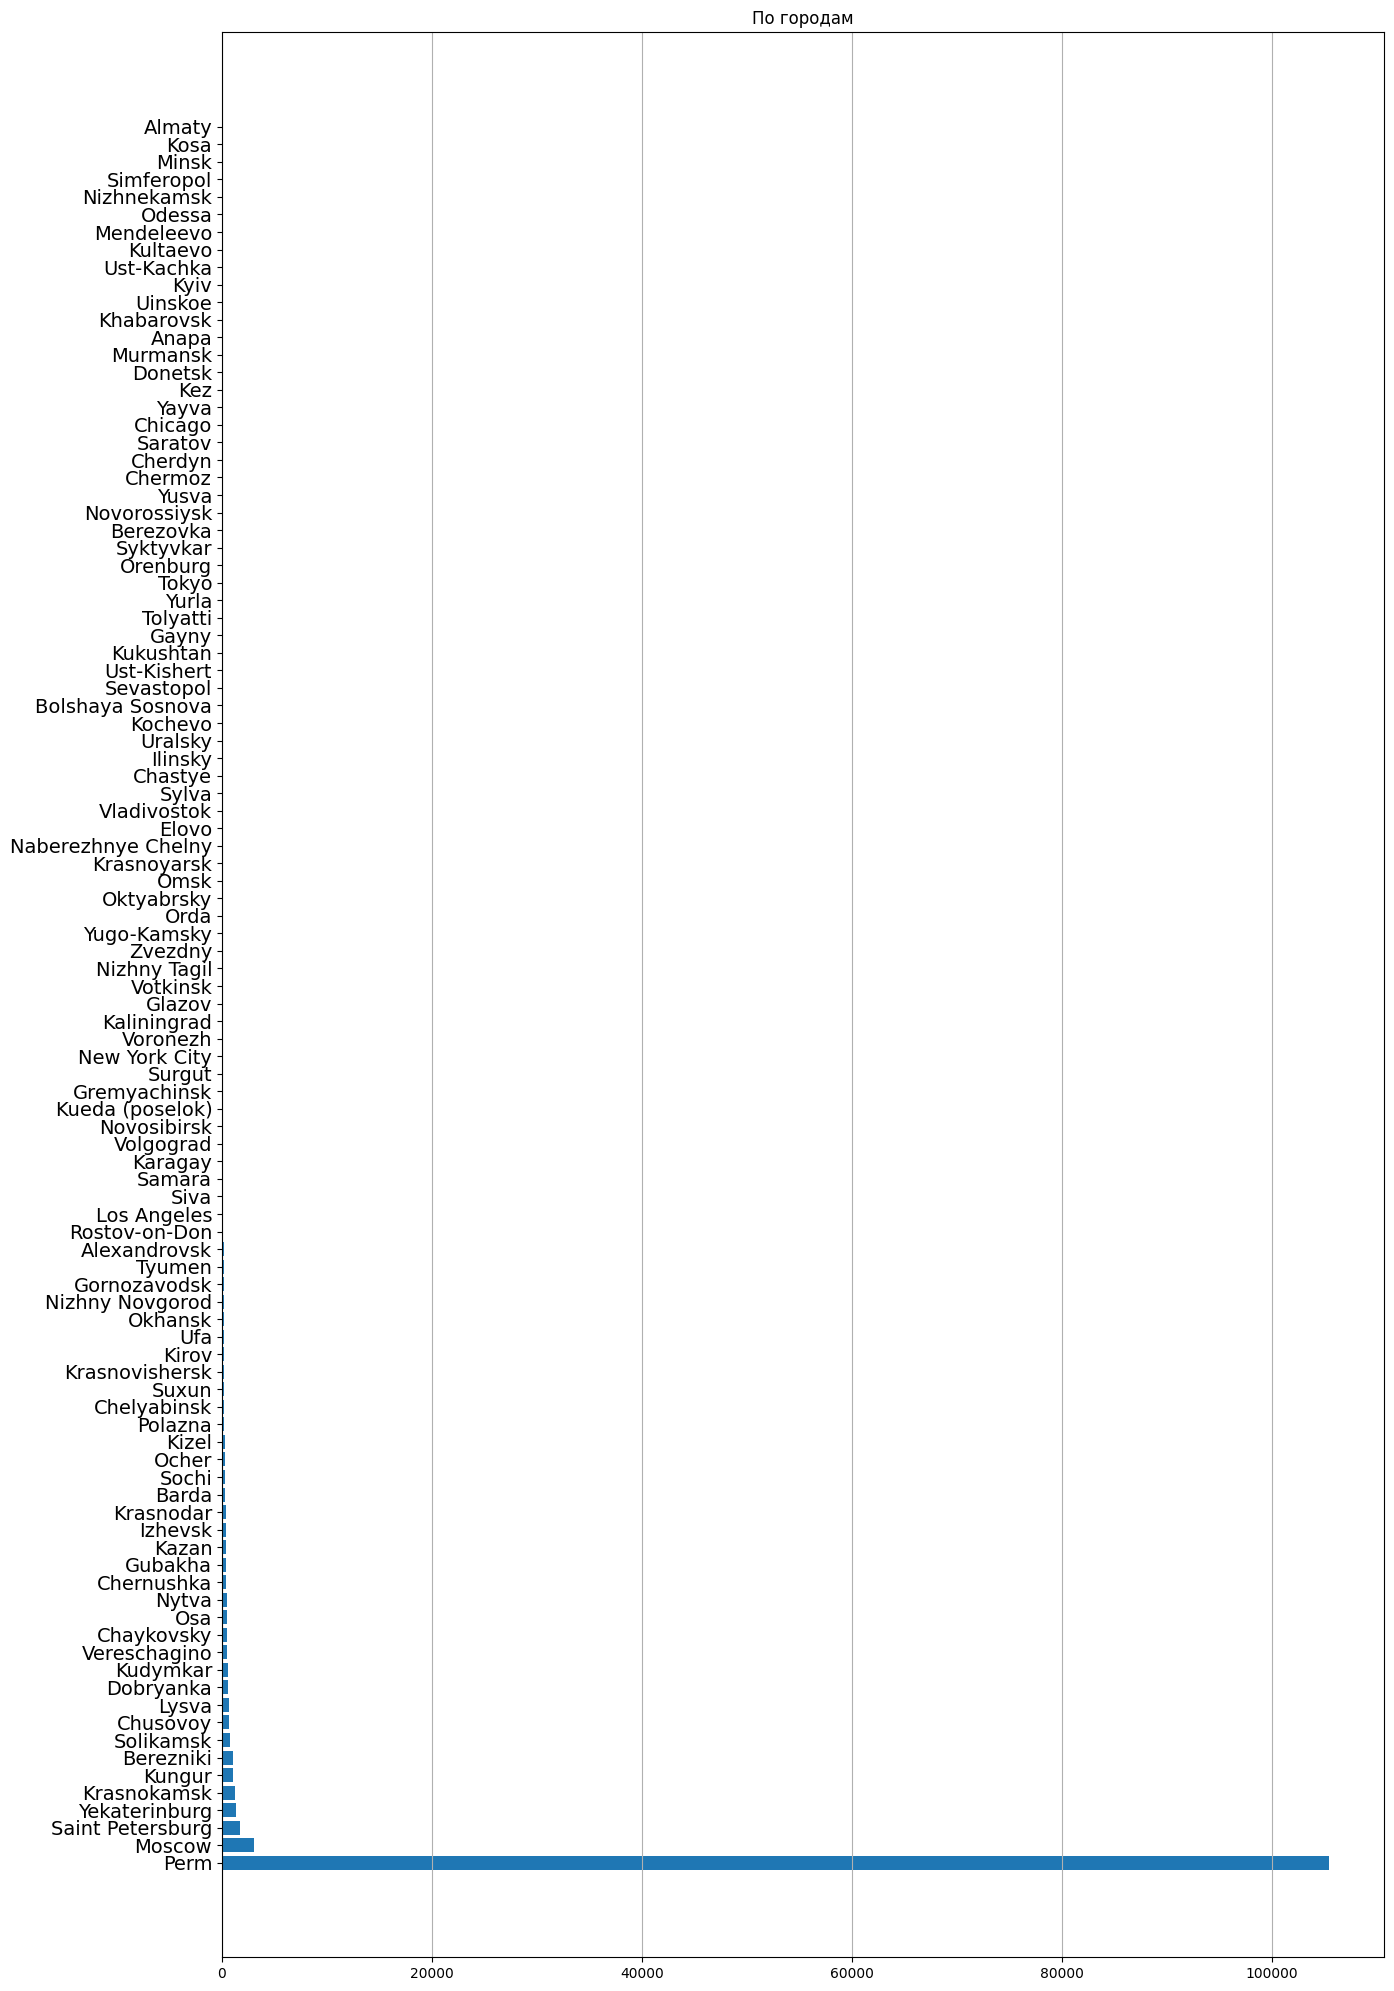

In [28]:
countplot_city(dr_group1_cleared)

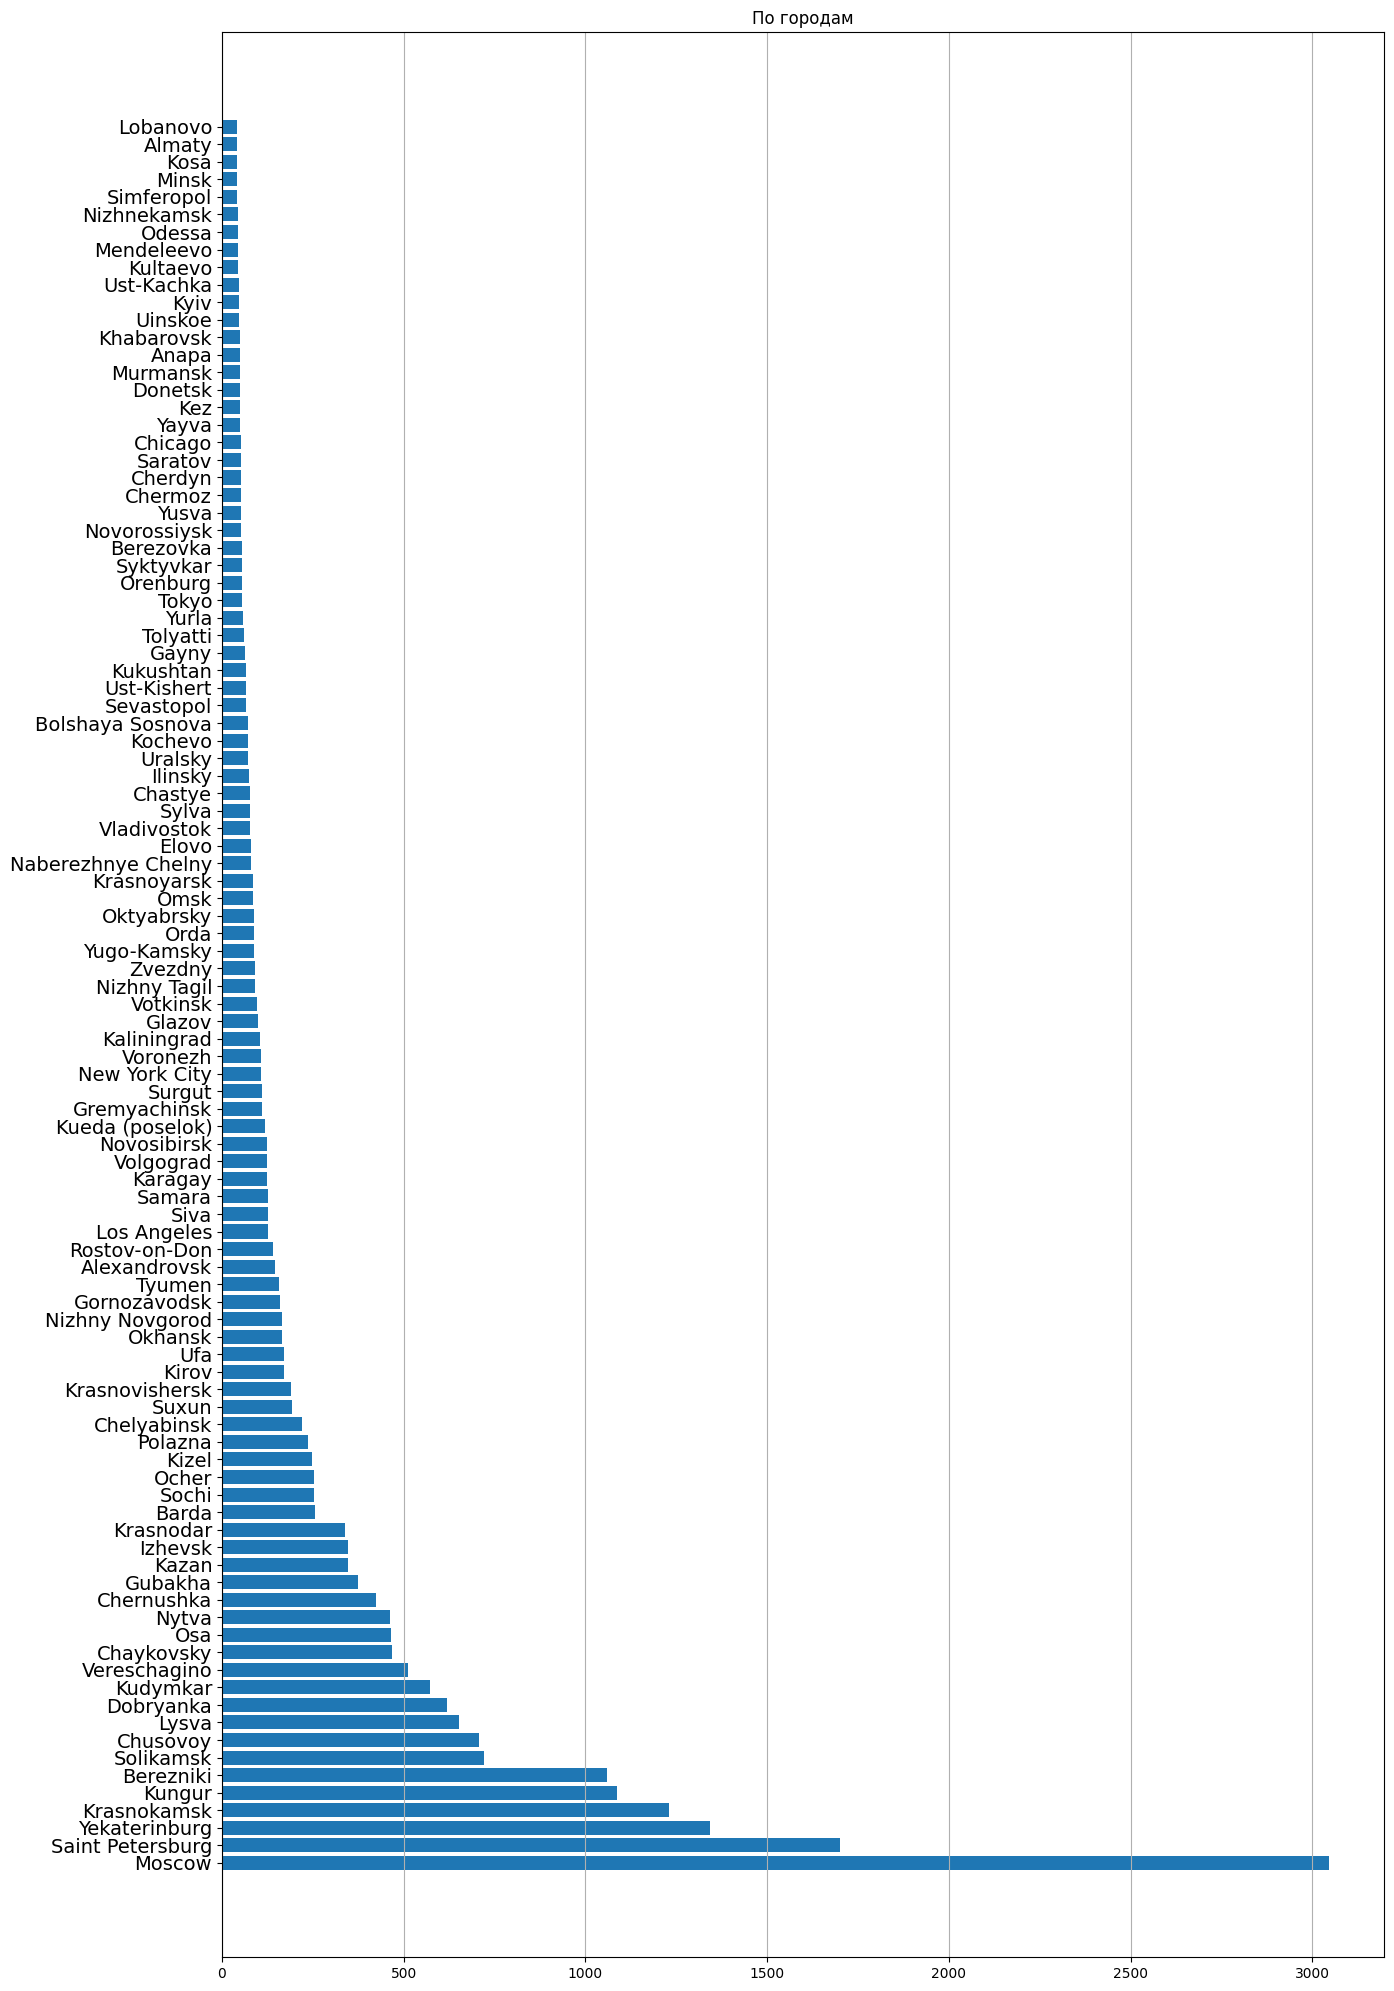

In [29]:
countplot_city(dr_group1_cleared, 100, 1)

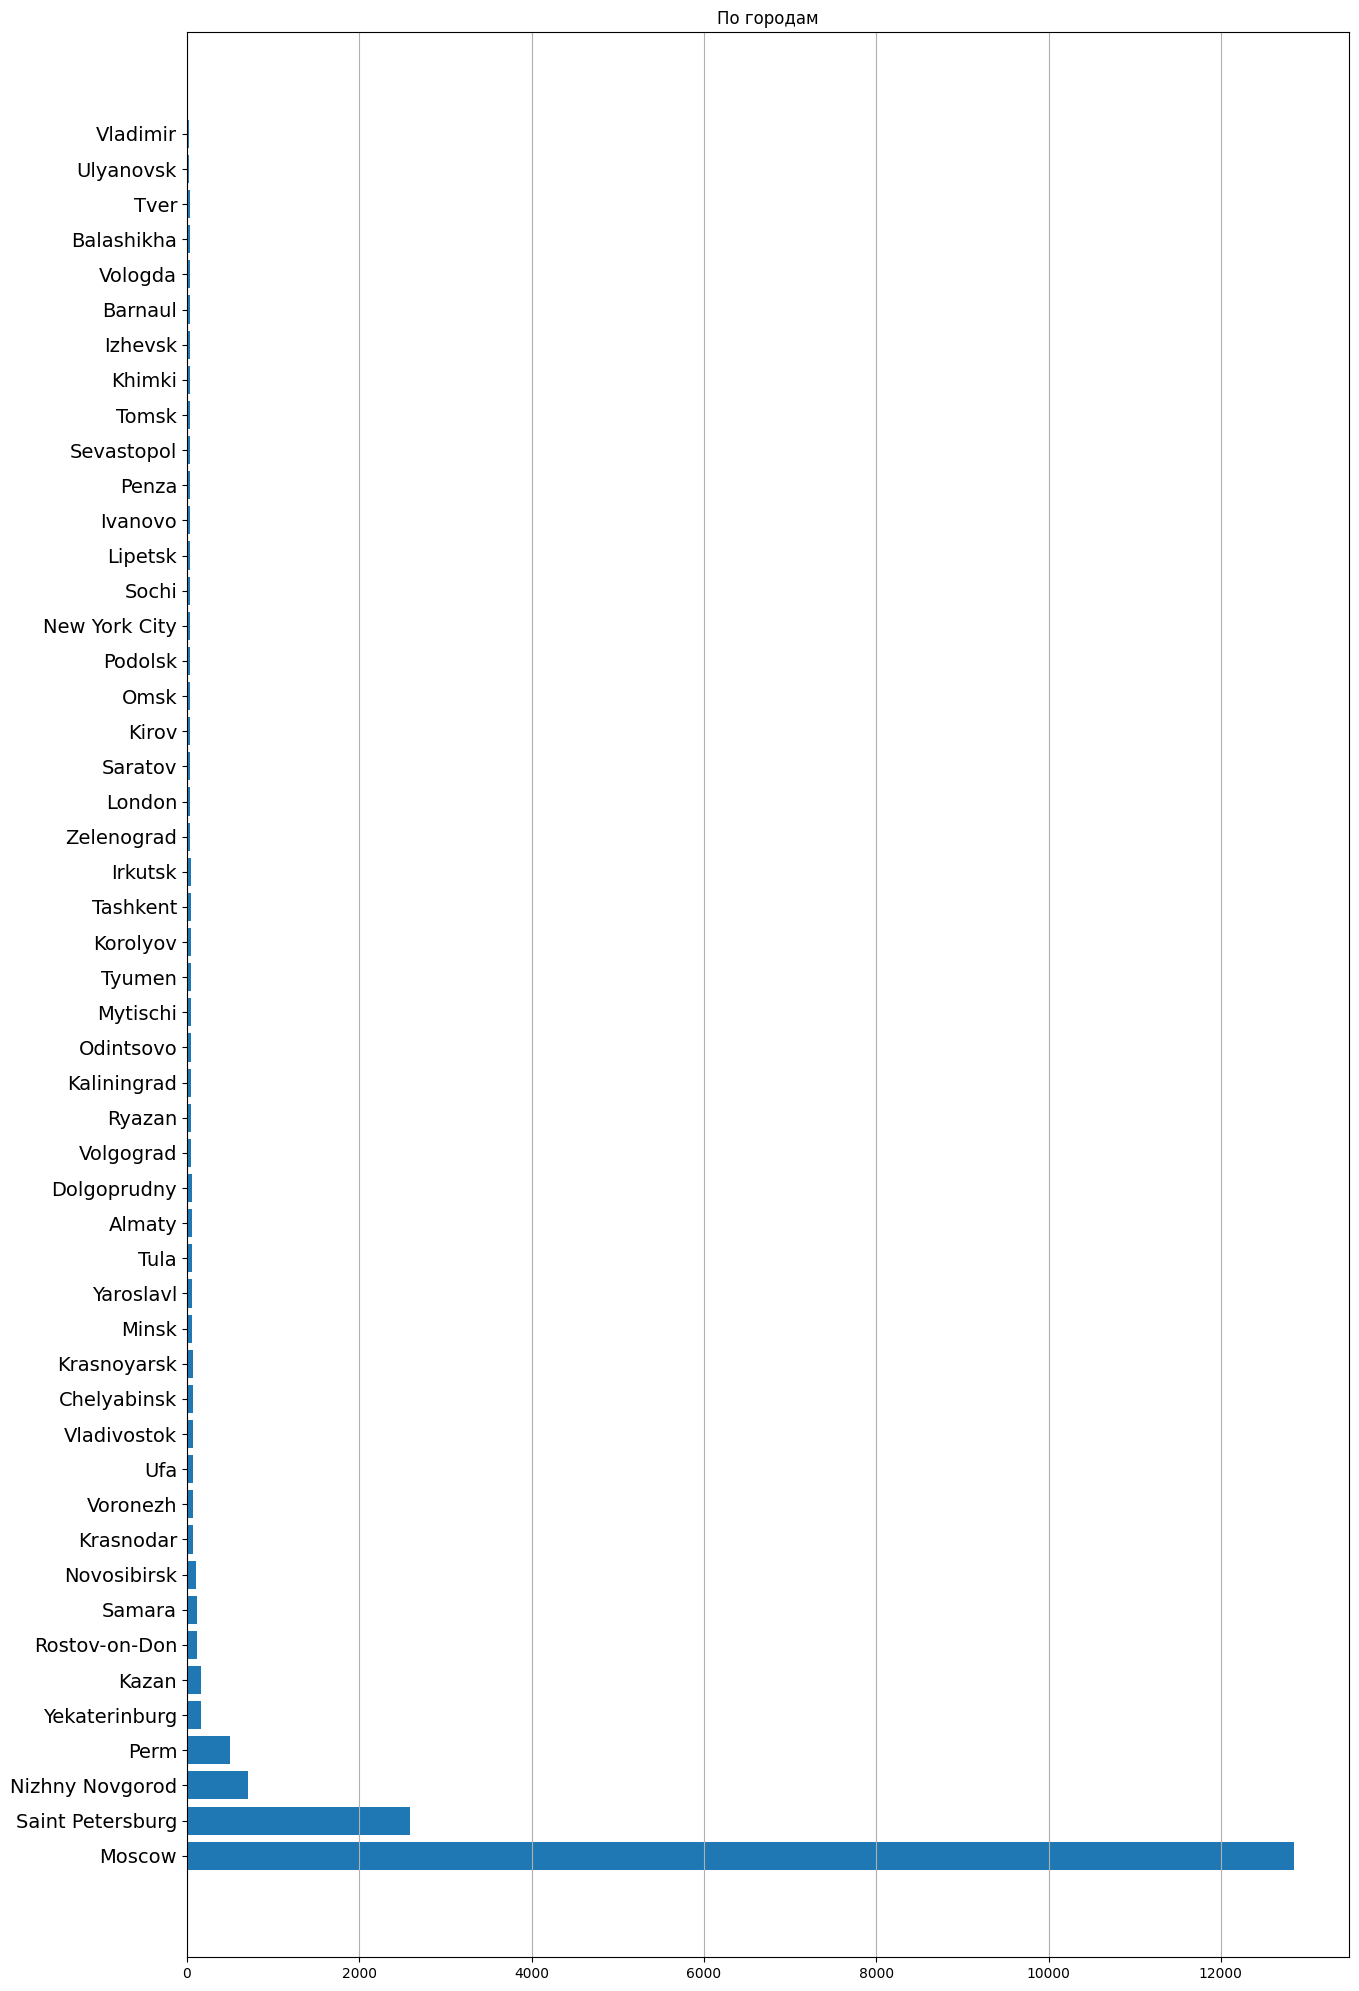

In [30]:
countplot_city(dr_group2_cleared, 50)

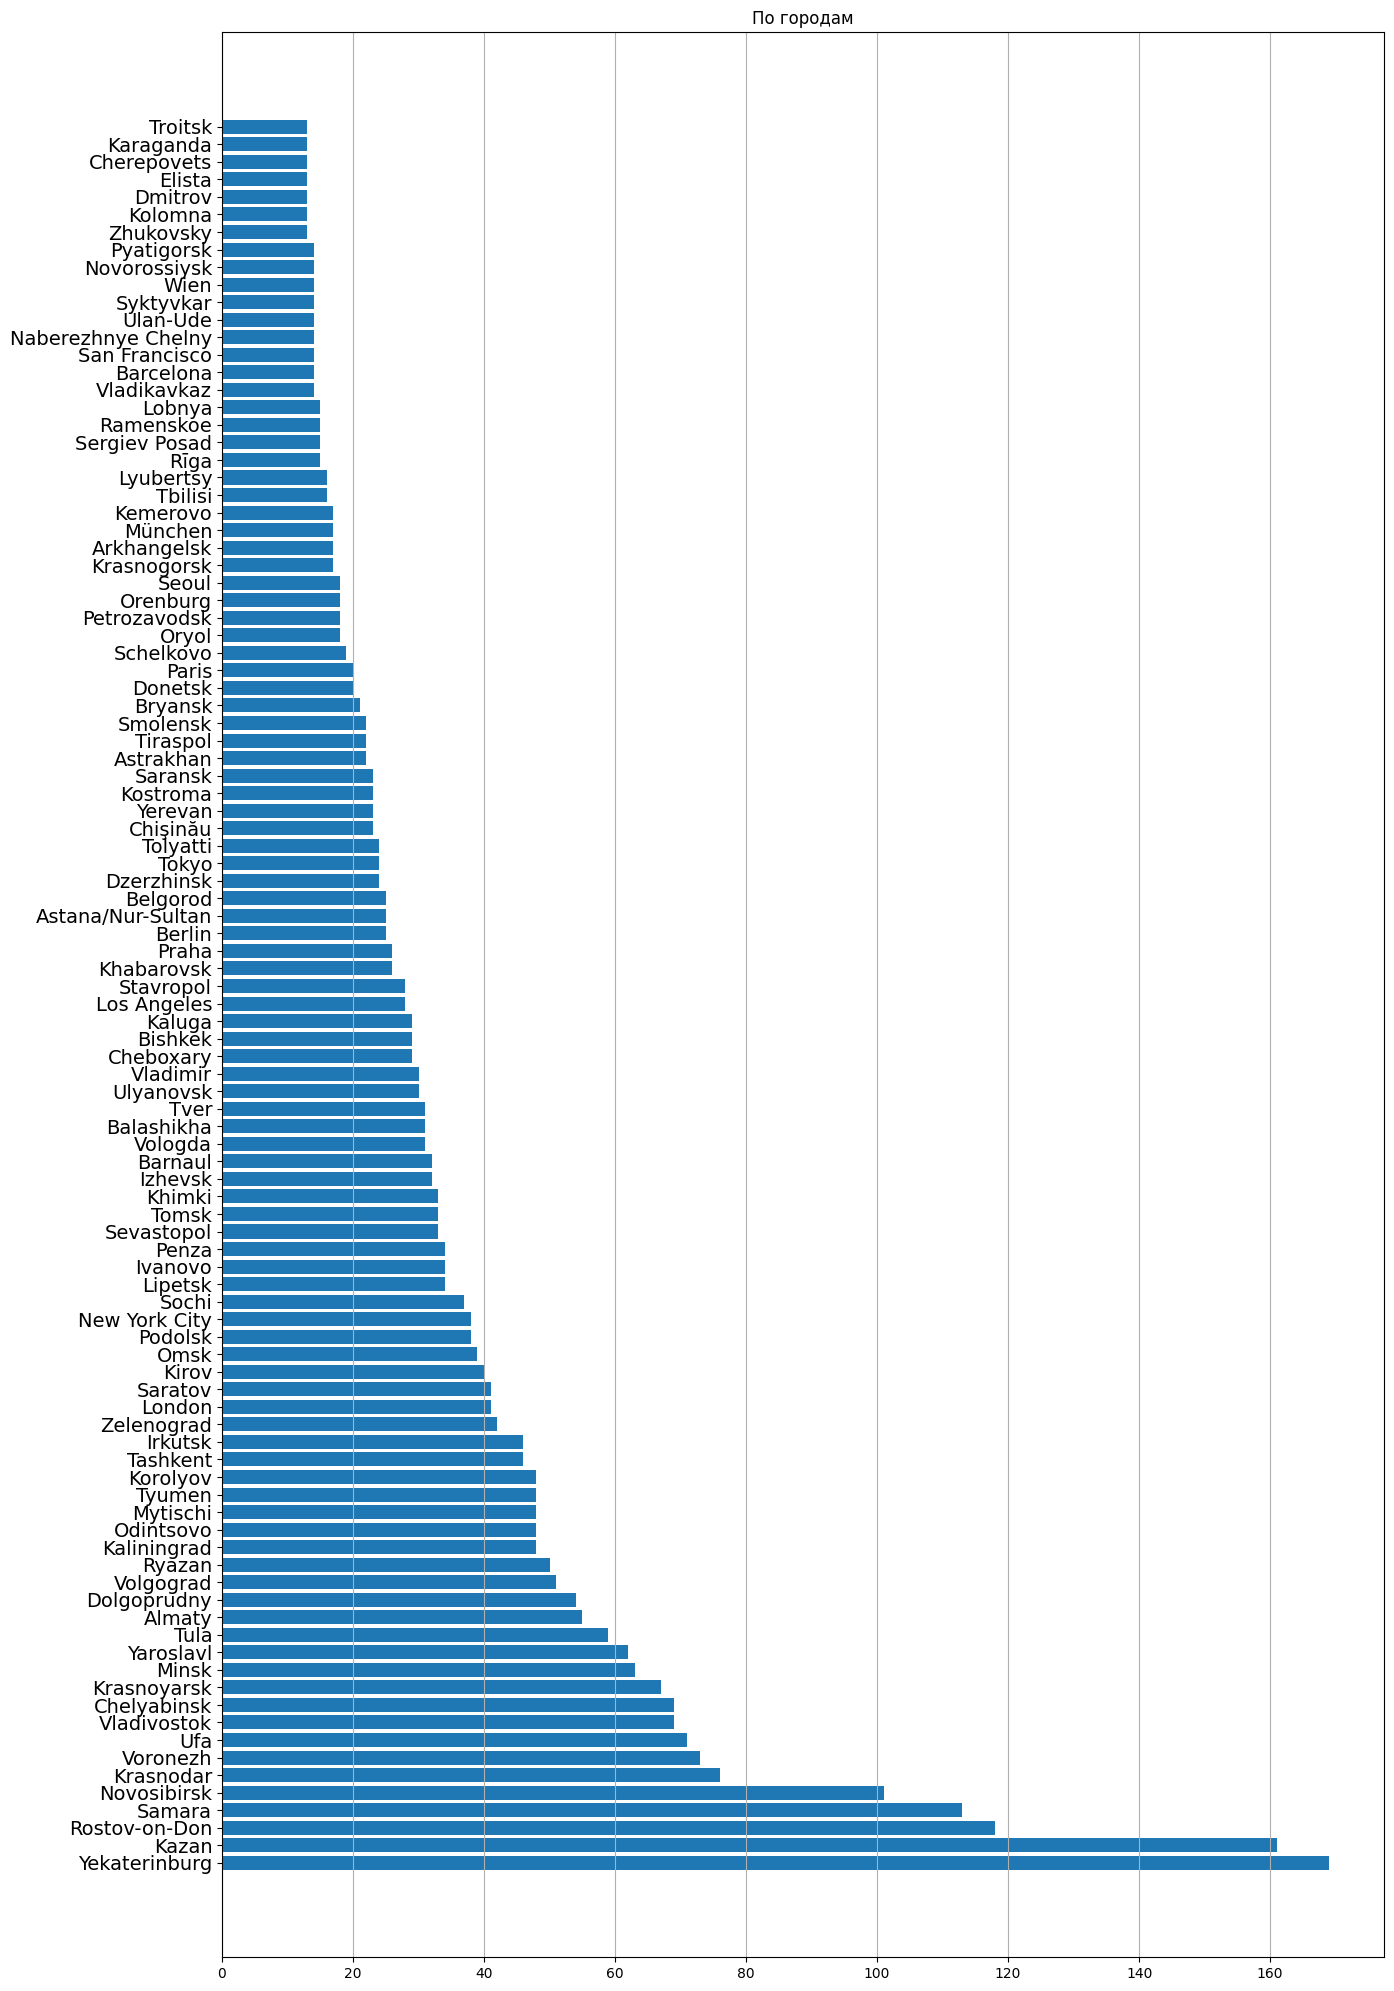

In [31]:
countplot_city(dr_group2_cleared, 100, 4)

In [34]:
df_intersect = get_users_info(list(intersection), user_fields)

1000 / 1203
1203 / 1203


In [35]:
df_intersect['byear'] = df_intersect['bdate'].str[-4:].apply(pd.to_numeric)
df_intersect.head(5)

,id,bdate,sex,first_name,last_name,can_access_closed,is_closed,city.id,city.title,country.id,country.title,deactivated,byear
0,220434432,17.5,2,Danya,Barshevsky,True,False,110.0,Perm,1.0,Russia,NaN,17.5
1,49641477,30.4.1997,1,Ksenia,Pleshivykh,False,True,110.0,Perm,1.0,Russia,NaN,1997.0
2,306397189,29.7,1,Ekaterina,Nichkova,True,False,110.0,Perm,1.0,Russia,NaN,29.7
3,324646920,18.7,1,Lyuda,Artemova,True,False,110.0,Perm,1.0,Russia,NaN,18.7
4,219332623,17.7,1,Irina,Tsaryova,True,False,110.0,Perm,1.0,Russia,NaN,17.7


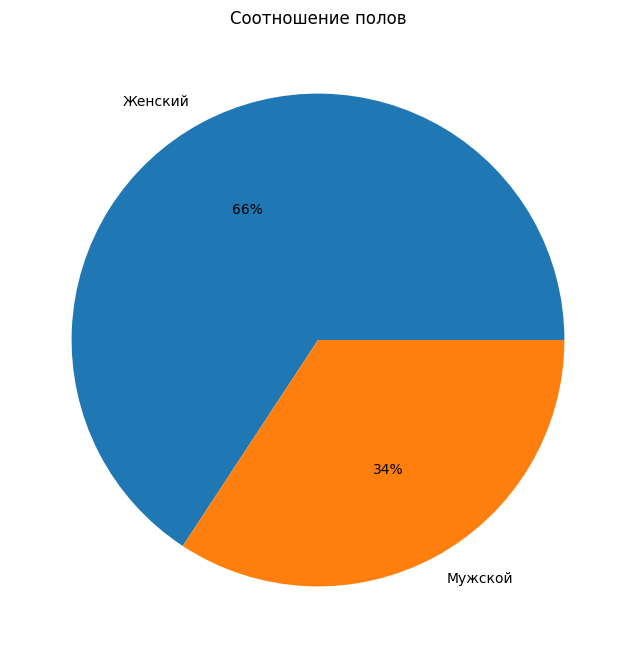

In [36]:
piechart_sex(df_intersect)

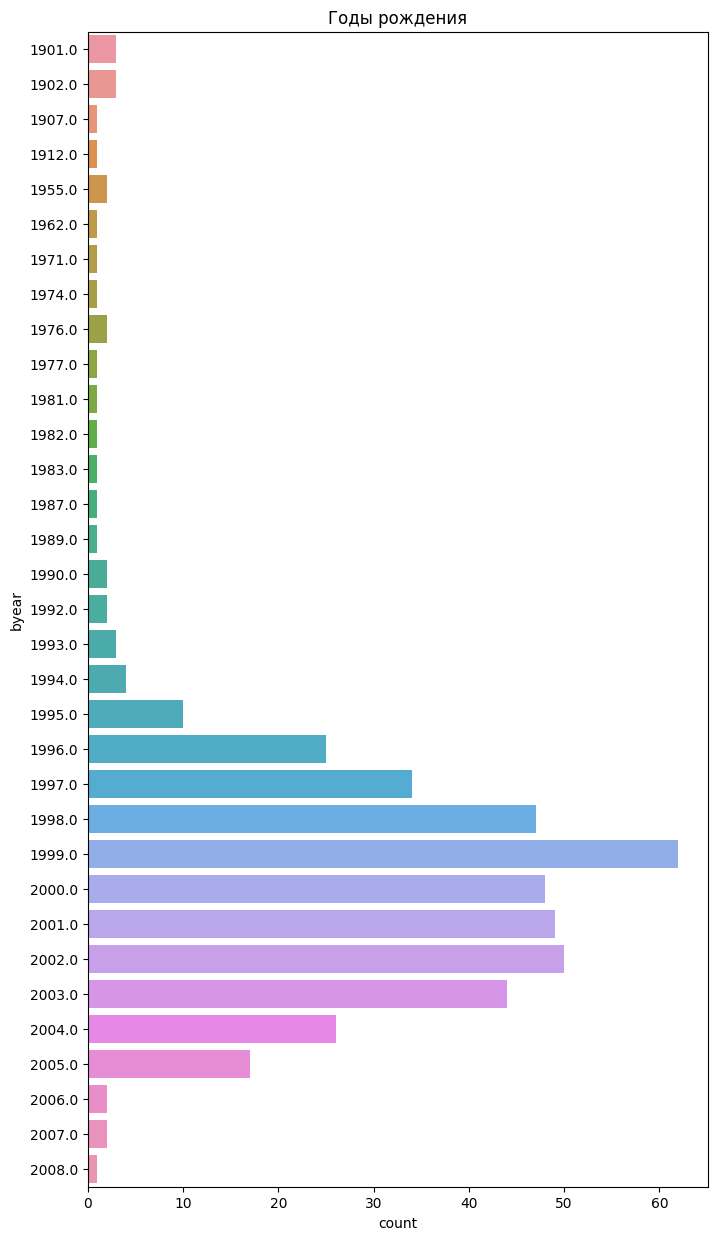

In [37]:
countplot_birth_year(df_intersect.loc[df_intersect['byear'] > 1900])

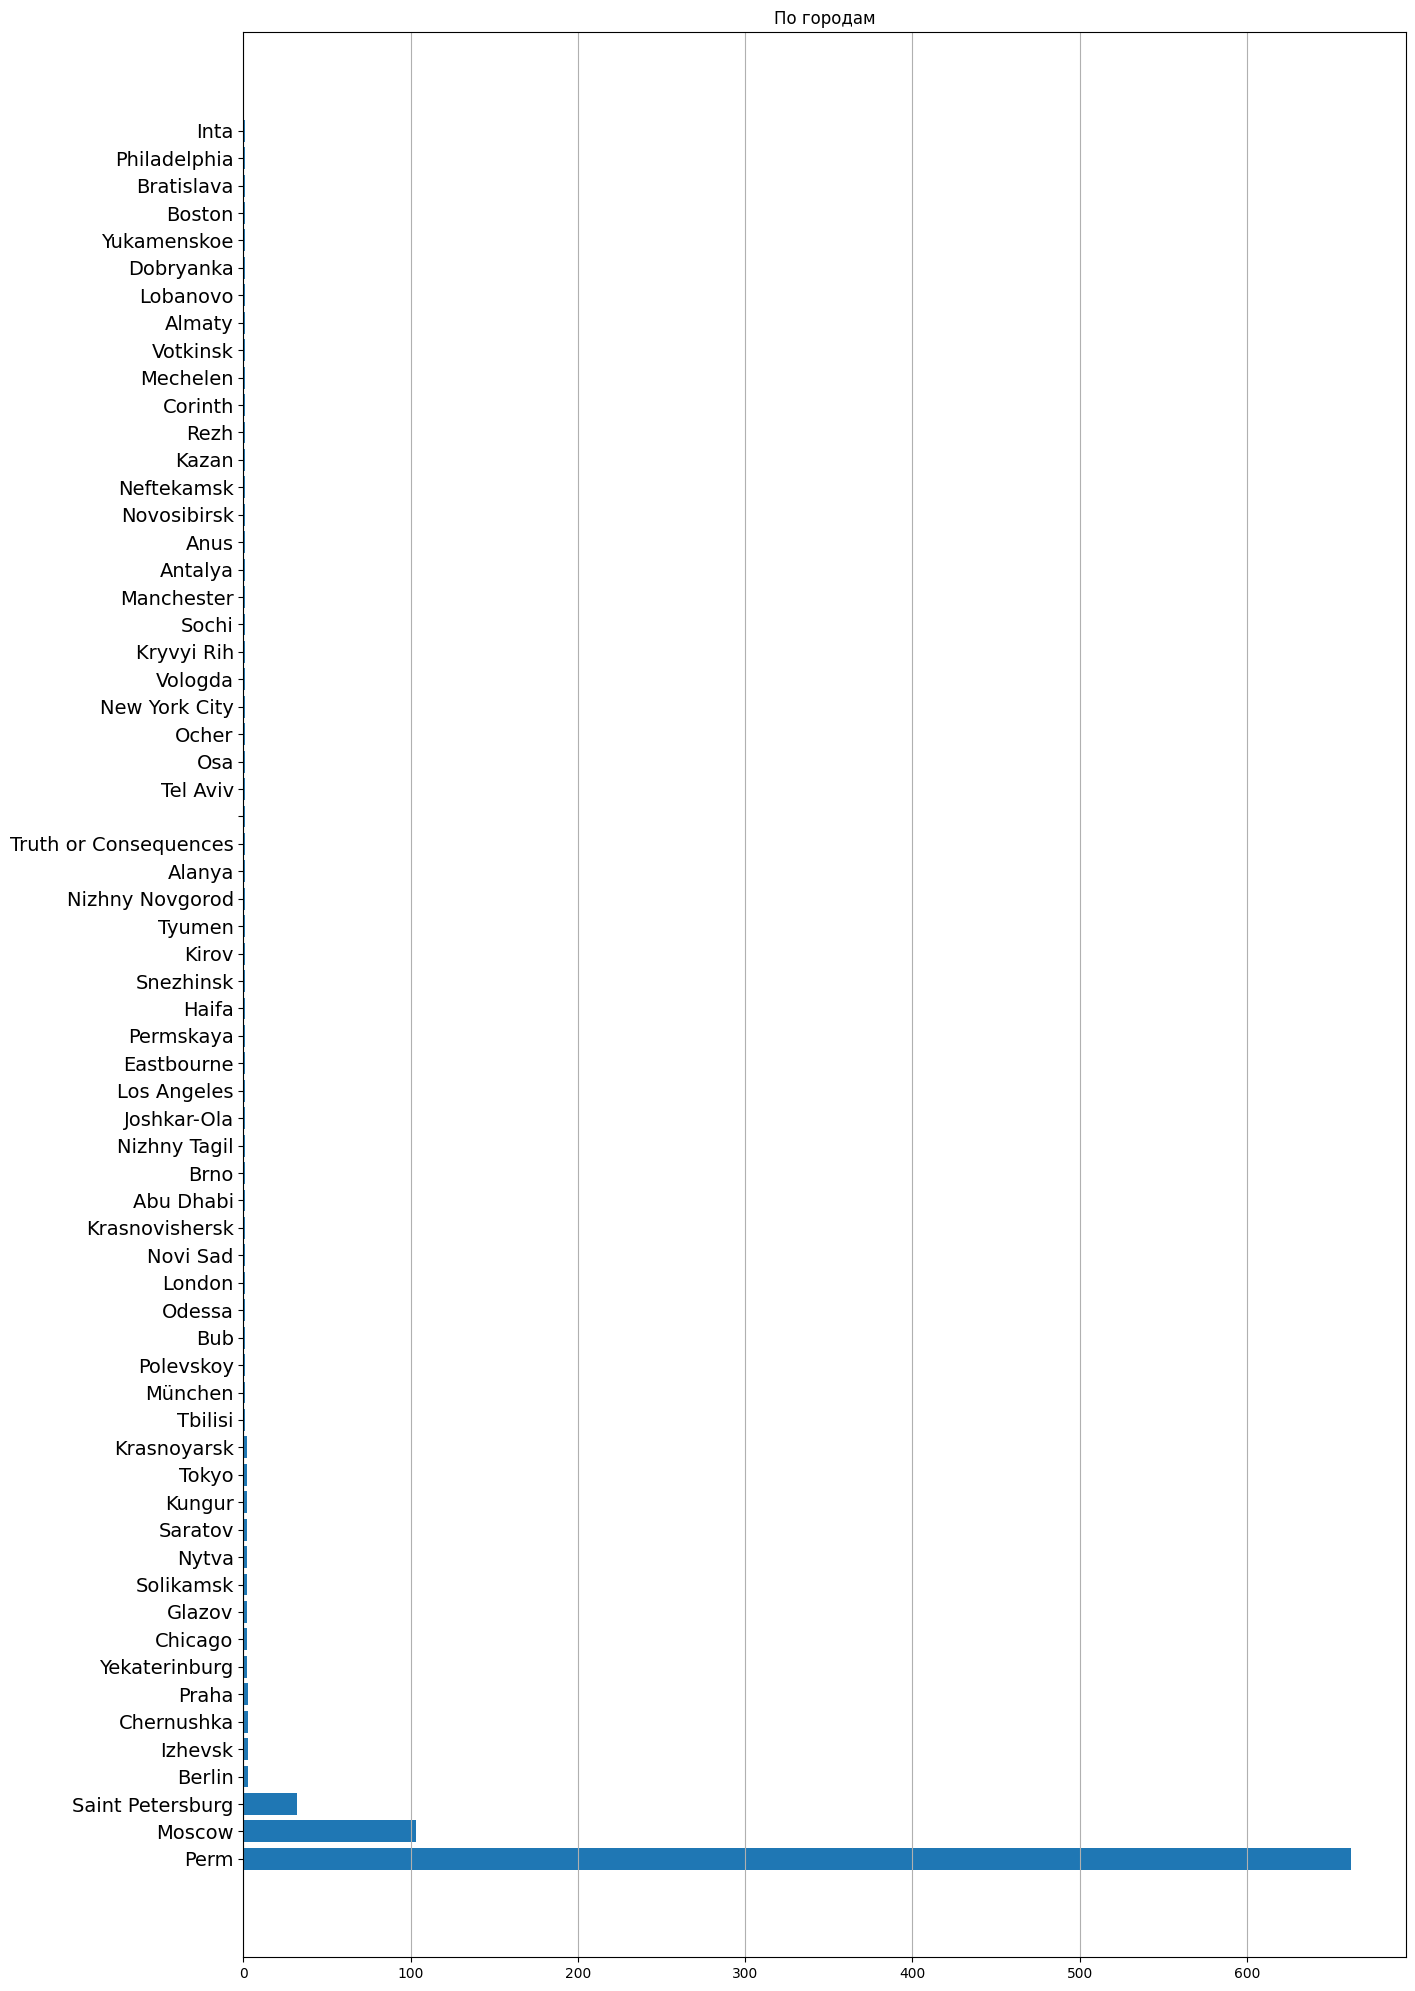

In [38]:
countplot_city(df_intersect)

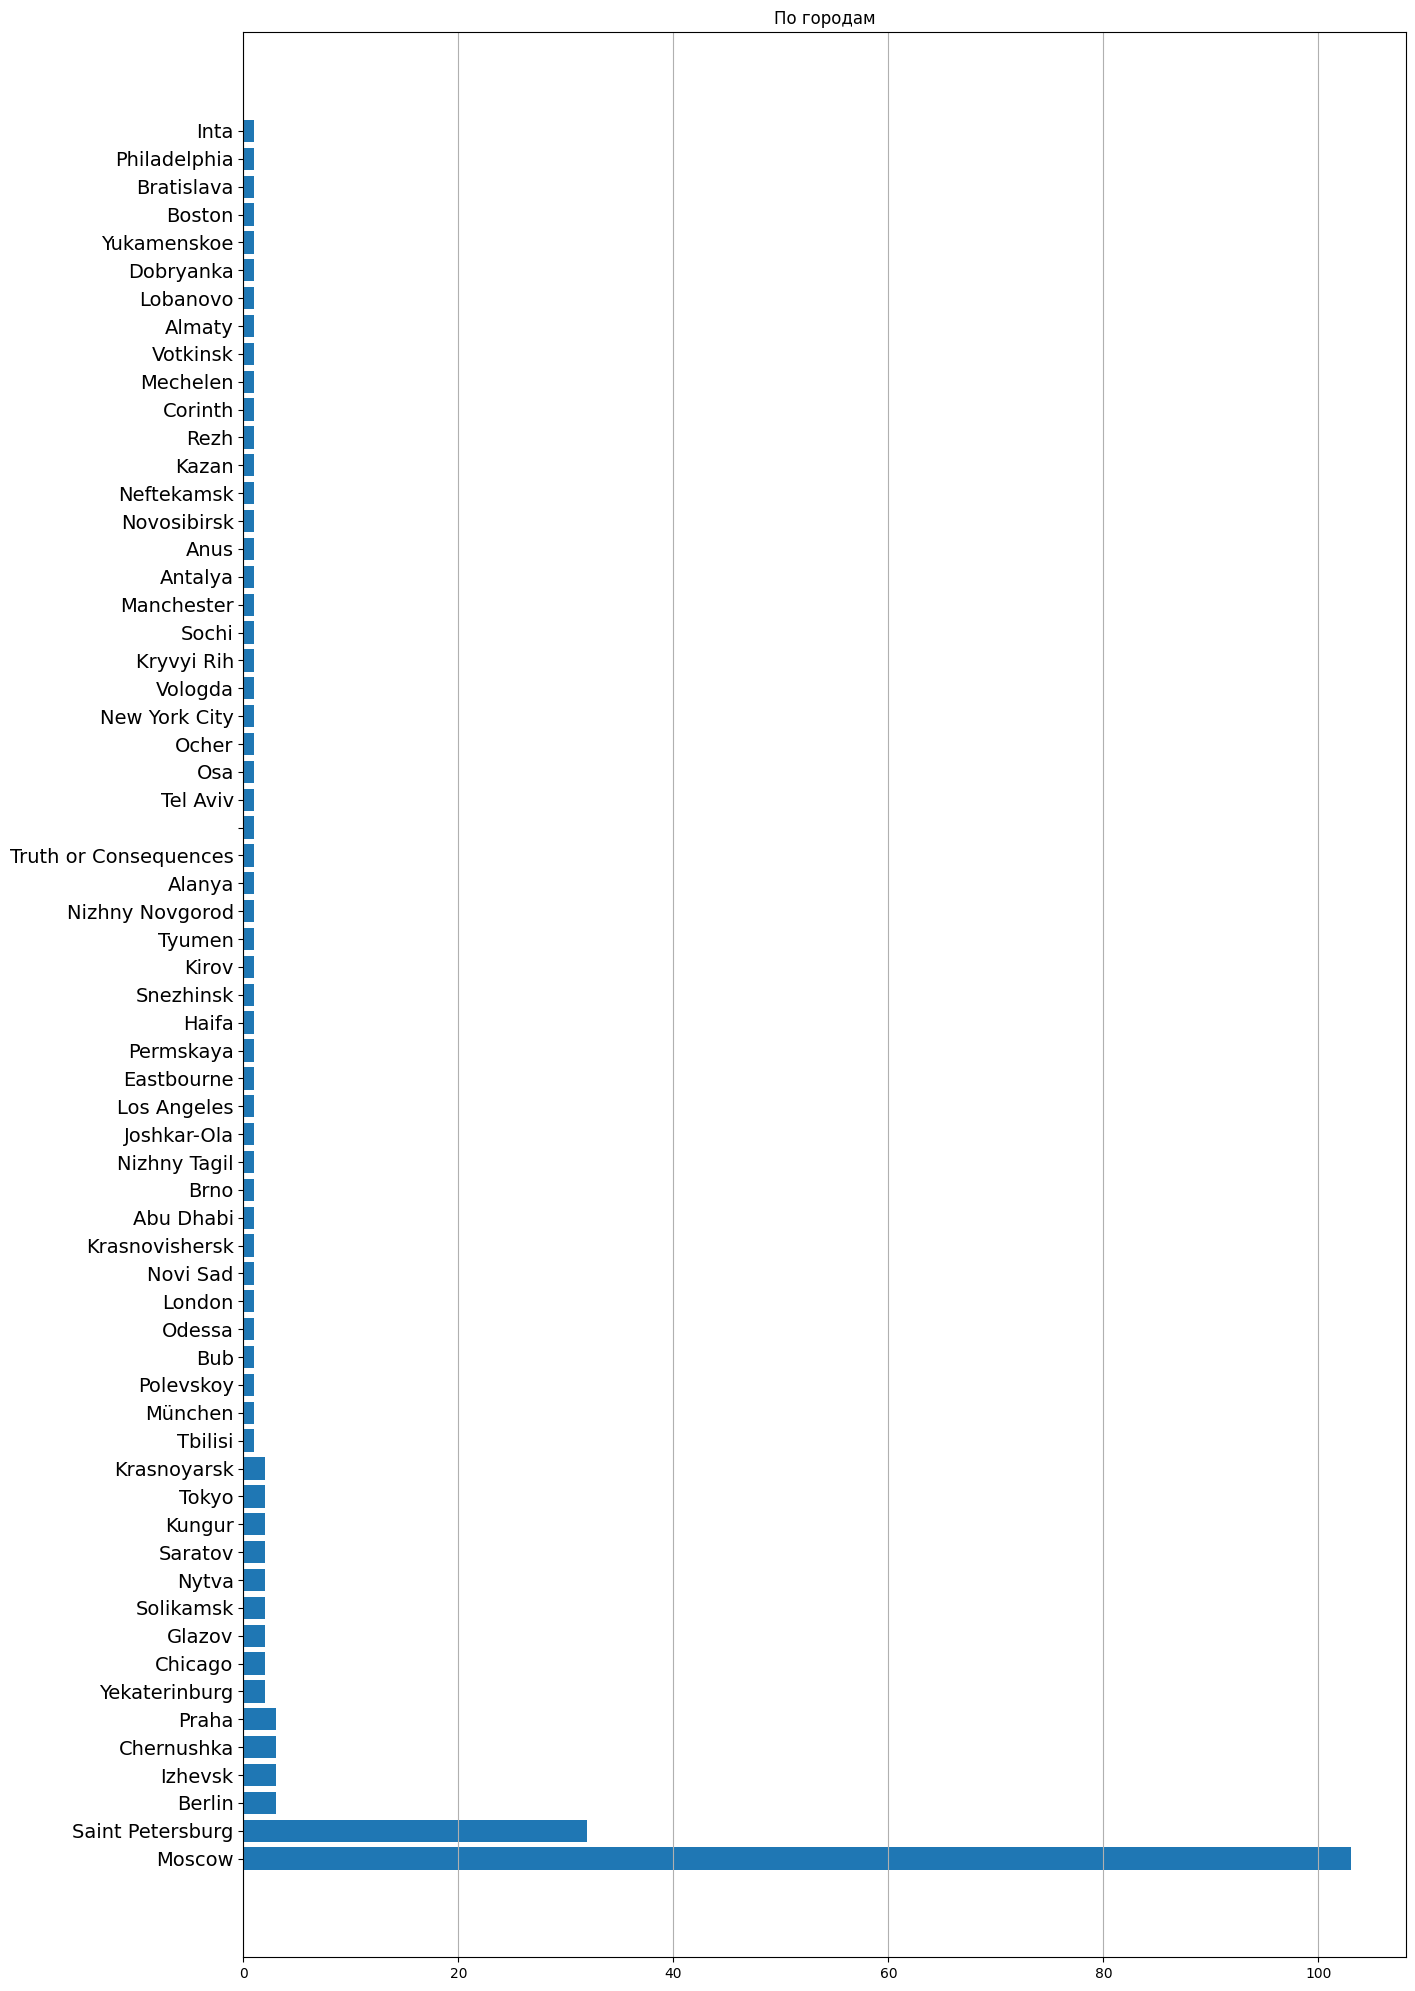

In [39]:
countplot_city(df_intersect, 100, 1)

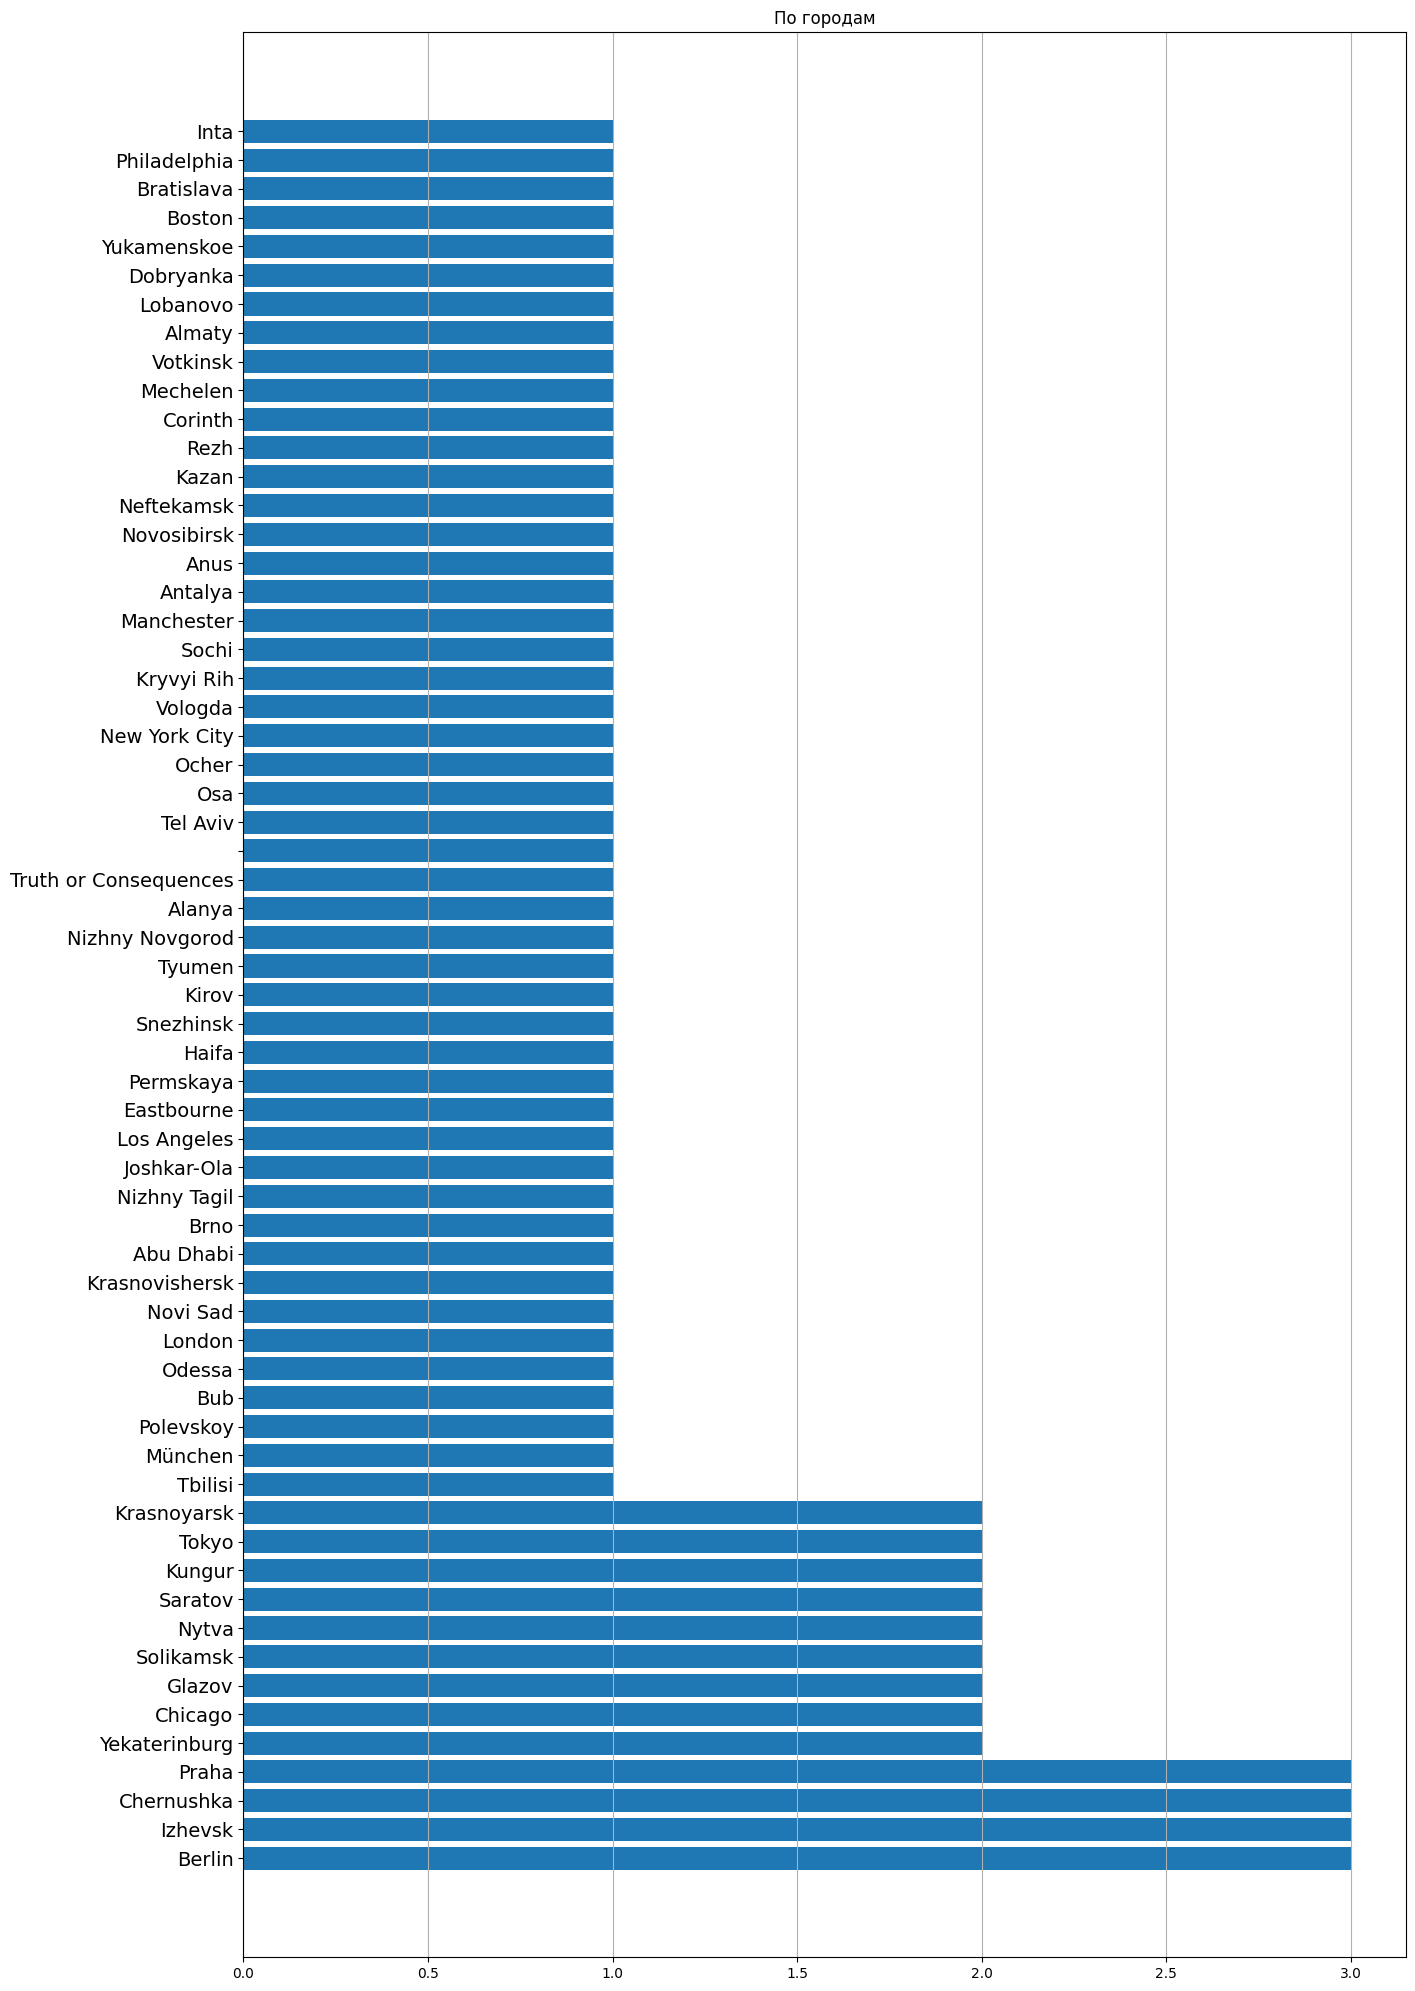

In [40]:
countplot_city(df_intersect, 100, 3)

In [41]:
avg3 = df_intersect.loc[(df_intersect['byear'] > 1920)]['byear'].mean()
print(f'Average birth year in intersection: {round(avg3)}')

Average birth year in intersection: 1999


In [46]:
dr_group1_cleared.head(5)

,id,bdate,sex,deactivated,first_name,last_name,can_access_closed,is_closed,city.id,city.title,country.id,country.title,byear
4,11834,7.5.1986,1,NaN,Natasha,Bayborodina,True,False,110.0,Perm,1.0,Russia,1986
5,15221,19.9.1985,1,NaN,Elnara,Petrova,True,False,2.0,Saint Petersburg,1.0,Russia,1985
7,28833,13.4.1988,2,NaN,Yura,Khodyrev,True,False,110.0,Perm,1.0,Russia,1988
11,43201,15.11.1984,2,NaN,Alexander,Vityukhovsky,False,True,110.0,Perm,1.0,Russia,1984
12,46999,3.9.1987,1,NaN,Anastasia,Usenkova,False,True,110.0,Perm,1.0,Russia,1987


In [56]:
df_member_cities = dr_group1_cleared[['city.title']].copy(deep=True)
df_member_cities['group'] = [group1_id for i in range(len(df_member_cities.index))]
df_member_cities2 = dr_group2_cleared[['city.title']].copy(deep=True)
df_member_cities2['group'] = [group2_id for i in range(len(df_member_cities2.index))]
df_member_cities = pd.concat([df_member_cities, df_member_cities2])
df_member_cities.head(5)

,city.title,group
4,Perm,vikiperm
5,Saint Petersburg,vikiperm
7,Perm,vikiperm
11,Perm,vikiperm
12,Perm,vikiperm


In [57]:
df_member_cities.tail(5)

,city.title,group
186,Moscow,hsemem
194,Moscow,hsemem
195,Moscow,hsemem
198,Moscow,hsemem
209,Samara,hsemem


In [58]:
len(df_member_cities.index)

160162

In [ ]:
G = nx.from_pandas_edgelist(df_member_cities, 'city.title', 'group')
colors = []

group1_cities = set(df_member_cities.loc[df_member_cities['group'] == group1_id]['city.title'])
group2_cities = set(df_member_cities.loc[df_member_cities['group'] == group2_id]['city.title'])

for x in G:
    in_group1 = False
    in_group2 = False

    if x in group1_cities:
        in_group1 = True

    if x in group2_cities:
        in_group2 = True

    if in_group1 and in_group2:
        colors.append('red')
    elif in_group1:
        colors.append('green')
    elif in_group2:
        colors.append('blue')
    else:
        colors.append('orange')

In [82]:
plt.figure(figsize=(70, 30))
nx.draw(G, with_labels=True, node_color=colors, edge_color='lightgray')

Output hidden; open in https://colab.research.google.com to view.

In [96]:
G_1 = nx.from_pandas_edgelist(df_member_cities.loc[
    df_member_cities['group'] == group1_id], 'city.title', 'group')
plt.figure(figsize=(70, 30))
nx.draw(G_1, with_labels=True, edge_color='lightgray')

Output hidden; open in https://colab.research.google.com to view.

In [97]:
G_2 = nx.from_pandas_edgelist(df_member_cities.loc[
    df_member_cities['group'] == group2_id], 'city.title', 'group')
plt.figure(figsize=(70, 30))
nx.draw(G_2, with_labels=True, edge_color='lightgray')

Output hidden; open in https://colab.research.google.com to view.

In [84]:
df_member_countries = dr_group1_cleared[['country.title']].copy(deep=True)
df_member_countries['group'] = [group1_id for i in range(len(df_member_countries.index))]
df_member_countries2 = dr_group2_cleared[['country.title']].copy(deep=True)
df_member_countries2['group'] = [group2_id for i in range(len(df_member_countries2.index))]
df_member_countries = pd.concat([df_member_countries, df_member_countries2])
df_member_countries.head(5)

,country.title,group
4,Russia,vikiperm
5,Russia,vikiperm
7,Russia,vikiperm
11,Russia,vikiperm
12,Russia,vikiperm


In [85]:
df_member_countries.tail(5)

,country.title,group
186,Russia,hsemem
194,Russia,hsemem
195,Russia,hsemem
198,Russia,hsemem
209,Russia,hsemem


In [89]:
G1 = nx.from_pandas_edgelist(df_member_countries, 'country.title', 'group')
colors = []

group1_countries = set(df_member_countries.loc[df_member_countries['group'] == group1_id]['country.title'])
group2_countries = set(df_member_countries.loc[df_member_countries['group'] == group2_id]['country.title'])

for x in G1:
    in_group1 = False
    in_group2 = False

    if x in group1_countries:
        in_group1 = True

    if x in group2_countries:
        in_group2 = True

    if in_group1 and in_group2:
        colors.append('red')
    elif in_group1:
        colors.append('green')
    elif in_group2:
        colors.append('blue')
    else:
        colors.append('orange')

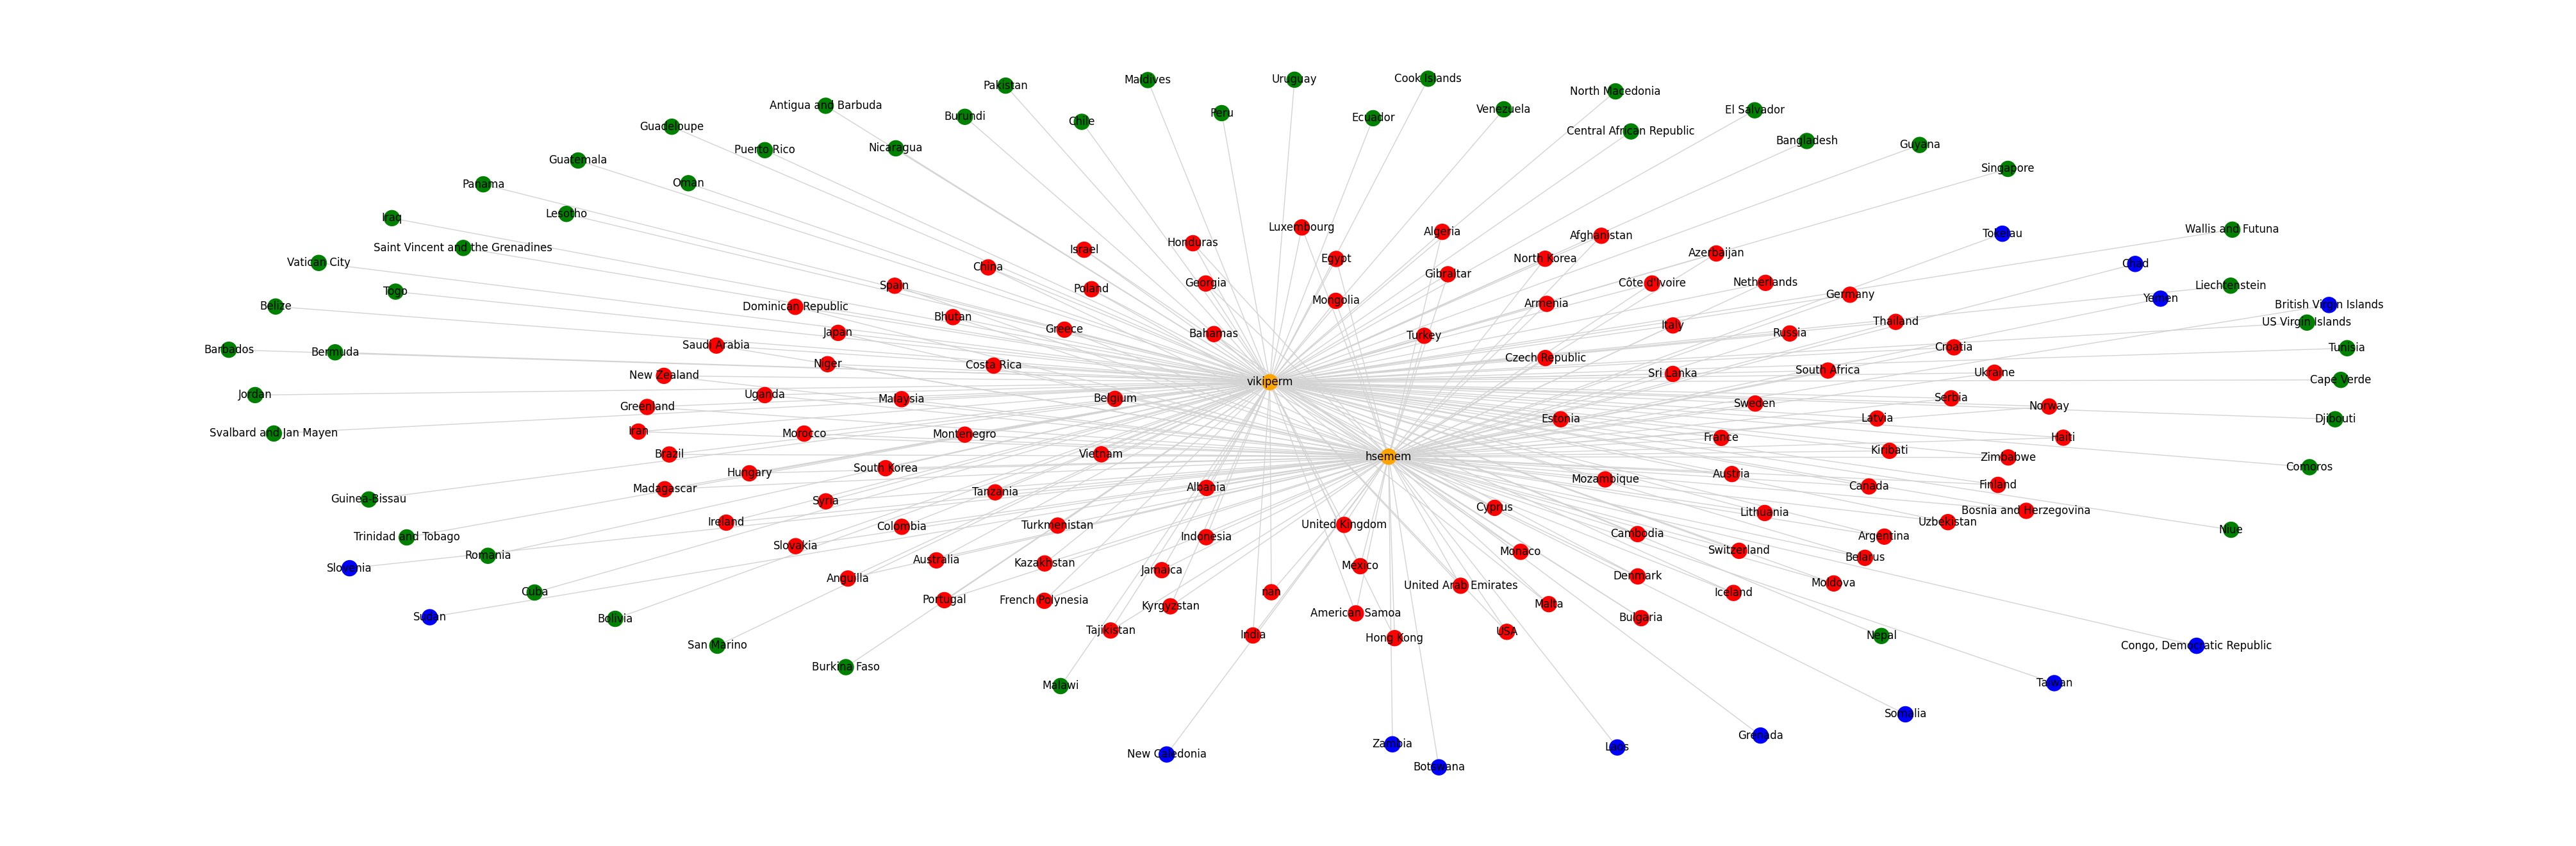

In [94]:
plt.figure(figsize=(40, 13))
nx.draw(G1, with_labels=True, node_color=colors, edge_color='lightgray')